In [1]:
import tensorflow as tf

import cv2
import numpy as np 
from matplotlib import pyplot as plt

import glob
import os 

import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
batch_size = 32
input_shape = (224, 224, 3)
learning_rate = 1e-4
epochs = 20

In [3]:
label_map = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

# Build model
- Using resnet152 as a backbone transfer learning

In [4]:
resnet_backbone = tf.keras.applications.ResNet152V2(
    weights='imagenet', include_top=False,
    input_shape=input_shape
)

In [5]:
for layer in resnet_backbone.layers[:-15]:
    layer.trainable = False

In [6]:
def get_renset_model(n_classes=6):
    x = resnet_backbone.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    
    return tf.keras.Model(resnet_backbone.input, output)

# Prepare data and set generator

In [58]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self, samples, batch_size=32, 
        input_shape=(150, 150), n_channels=3, n_classes=6, 
        shuffle=True, augment=False
    ):
        self.samples = samples
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        self.classes = [s[1] for s in self.samples]
        
    def __len__(self):
        return int(np.floor(len(self.samples) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_samples = [self.samples[k] for k in indexes]
        
        # Generate data
        X, y = self.data_generator(batch_samples)
        
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.samples))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def data_generator(self, batch_samples):
        X = np.empty((self.batch_size, *self.input_shape, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, batch_sample in enumerate(batch_samples):
            image_path = batch_sample[0]
            label = batch_sample[1]
            
            img = cv2.imread(image_path)
            img = cv2.resize(img, self.input_shape)
            img = img / 255

            X[i, ] = img
            y[i] = label
        
        if self.augment:
            X = self.augmentor(X)
            
        return X , tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def get_classes():
        self.samples[:10]
    
    def augmentor(self, images):
        'Apply data augmentation'
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.3),
            sometimes(iaa.Affine(
                scale={'x': (0.8, 1.2), 'y': (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                rotate=(-45, 45),
                shear=(-16, 16),
                order=[0, 1],
                cval=(0, 255),
                mode=ia.ALL
            )),
#             sometimes(iaa.CropAndPad(
#                 percent=(-0.05, 0.1),
#                 pad_mode=ia.ALL,
#                 pad_cval=(0, 255)
#             )),
#             iaa.SomeOf((0, 5), [
#                 # Run one of the following
#                 iaa.OneOf([
#                     iaa.GaussianBlur((0, 3.0)),
#                     iaa.AverageBlur(k=(2, 7)),
#                     iaa.MedianBlur(k=(3, 11))
#                 ]),
#                 iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
#                 iaa.OneOf([
#                     iaa.Multiply((0.5 , 1.5), per_channel=0.5),
#                     iaa.FrequencyNoiseAlpha(
#                         exponent=(-4, 0),
#                         first=iaa.Multiply((0.5, 1.5), per_channel=True),
#                         second=iaa.LinearContrast((0.5, 2.0))
#                     )
#                 ])
#             ], random_order=True)
        ], random_order=True)
        
        
        return seq(images=images)

In [8]:
def load_samples(image_dir):
    images_dir = glob.glob(image_dir + '*/*.jpg')
    samples = []
    
    for image_dir in images_dir:
        label = os.path.basename(os.path.dirname(image_dir))
        samples.append([
            image_dir, label_map[label]
        ])
    
    return samples

In [9]:
train_samples = load_samples('data/seg_train/seg_train/')
test_samples = load_samples('data/seg_test/seg_test/')

In [59]:
train_generator = DataGenerator(
    train_samples, batch_size=batch_size, input_shape=(224, 224), n_classes=6, augment=True
)

test_generator = DataGenerator(
    test_samples, batch_size=batch_size, input_shape=(224, 224), n_classes=6
)

# Compile and train model

In [11]:
model = get_renset_model()

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.4, 
    min_lr=0.0001
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto'
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'weights/resnet_152_weights.h5', 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    mode='max'
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_samples) // batch_size,
    validation_data=test_generator,
    validation_steps=len(test_samples) // batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 438 steps, validate for 93 steps
Epoch 1/20
437/438 [============================>.] - ETA: 0s - loss: 1.4223 - accuracy: 0.4129
Epoch 00001: val_accuracy improved from -inf to 0.76680, saving model to weights/resnet_152_weights.h5
438/438 [==============================] - 158s 361ms/step - loss: 1.4219 - accuracy: 0.4130 - val_loss: 0.6698 - val_accuracy: 0.7668
Epoch 2/20
437/438 [============================>.] - ETA: 0s - loss: 1.1442 - accuracy: 0.5397
Epoch 00002: val_accuracy improved from 0.76680 to 0.81452, saving model to weights/resnet_152_weights.h5
438/438 [==============================] - 116s 264ms/step - loss: 1.1434 - accuracy: 0.5400 - val_loss: 0.4962 - val_accuracy: 0.8145
Epoch 3/20
437/438 [============================>.] - ETA: 0s - loss: 1.0809 - accuracy: 0.5666
Epoch 00003: val_accuracy improved from 0.81452 to 0.82224, savi

In [107]:
model.evaluate(test_generator)

  ...
    to  
  ['...']
93/93 [==============================] - 19s 208ms/step - loss: 0.4161 - accuracy: 0.8589


[0.4161036345426754, 0.858871]

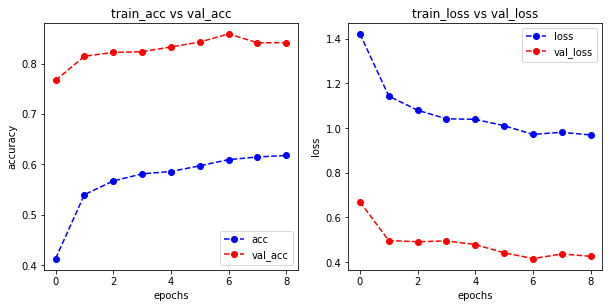

In [14]:
# Lets plot the history
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label='acc')
plt.plot(history.history['val_accuracy'], 'ro--', label='val_acc')
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label='loss')
plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")

plt.legend()
plt.show()

In [15]:
pred_images = glob.glob('data/seg_pred/seg_pred/*.jpg')
# labels = [os.path.basename(folders) for folders in glob.glob('data/seg_train/seg_train/*')]
labels = list(label_map.keys())

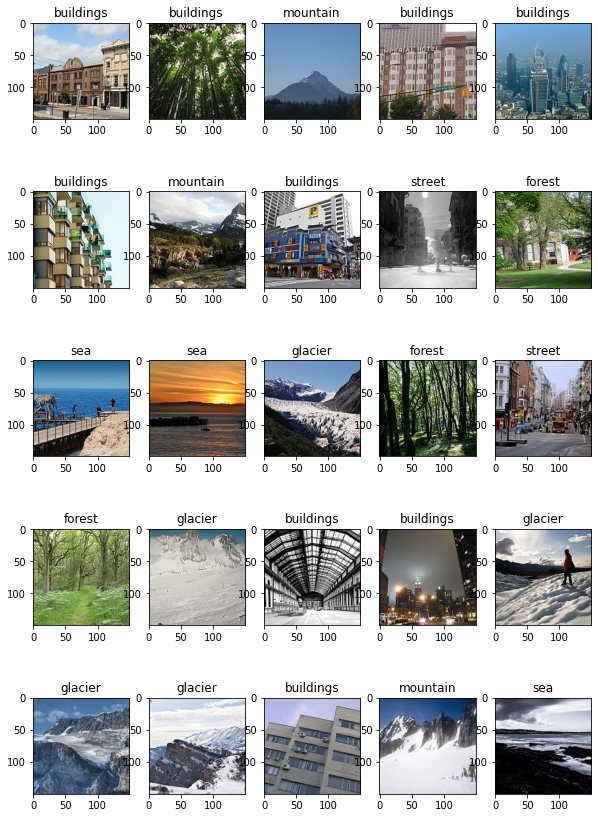

In [74]:
# prepare image for inference
np.random.shuffle(pred_images)

row = 5
column = 5
count = 0
plt.figure(figsize=(10, 15))

for pred_image in pred_images:
    img = cv2.imread(pred_image)
    img_copy = img.copy()
    img_copy = cv2.resize(img, (224, 224))
    img_copy = img_copy / 255
    img_copy = np.expand_dims(img_copy, axis=0)

    preds = model.predict(img_copy)

    pred_max = np.argmax(preds)
    
    count += 1
    plt.subplot(row, column, count)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(labels[pred_max])
    if count == row * column:
        break

# Evaluation

In [121]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [17]:
model = tf.keras.models.load_model('weights/resnet_152_weights.h5')

In [122]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [123]:
cm = confusion_matrix(test_generator.classes[:2976], y_pred)

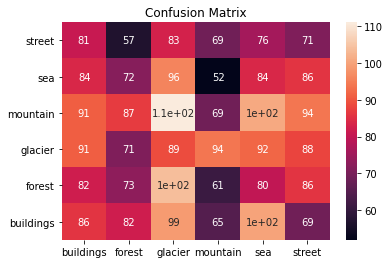

In [124]:
ax = plt.subplot()
ax.set_title('Confusion Matrix'); 
sns.heatmap(cm, annot=True, ax=ax, xticklabels=labels, yticklabels=labels[::-1])

In [126]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

TP, FP, FN, TN

(72, 57, 84, 81)

In [127]:
print(classification_report(test_gen.classes[:2976], y_pred, target_names=labels))

              precision    recall  f1-score   support

   buildings       0.16      0.19      0.17       437
      forest       0.17      0.16      0.16       474
     glacier       0.19      0.20      0.20       553
    mountain       0.15      0.11      0.13       525
         sea       0.17      0.17      0.17       510
      street       0.17      0.18      0.17       477

    accuracy                           0.17      2976
   macro avg       0.17      0.17      0.17      2976
weighted avg       0.17      0.17      0.17      2976

